# PyTorch in 12 Minutes 48 seconds

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
from tqdm import tqdm
import timeit

## Autograd

In [27]:
x = torch.ones(2, 2, requires_grad=True)
print(x.grad)
print(x.grad_fn)  # we've created x ourselves


None
None


In [28]:
y = x**2 + 2
print(y.grad)
print(y.grad_fn)


None


In [29]:
y.sum().backward()

In [30]:
print(x)
print(y)
print(x.grad)

tensor([[ 1.,  1.],
        [ 1.,  1.]])
tensor([[ 3.,  3.],
        [ 3.,  3.]])
tensor([[ 2.,  2.],
        [ 2.,  2.]])


In [31]:
# Useful in transfer learning, etc.
# Freeze weights in the model, change classifier layer
# Only update classifier layer.

res_model = torchvision.models.resnet18(pretrained=True)
for param in res_model.parameters():
    param.requires_grad = False
# Replace the last fully-connected layer
# Parameters of newly constructed modules have requires_grad=True by default
res_model.fc = nn.Linear(512, 100)

# Optimize only the classifier
res_optimizer = optim.SGD(res_model.fc.parameters(), lr=1e-2, momentum=0.9)

## Load Datasets

In [32]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 49000
NUM_VAL = 1000

cifar10_train = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(cifar10_train, batch_size=64, sampler=ChunkSampler(NUM_TRAIN, 0))

cifar10_val = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                           transform=T.ToTensor())
loader_val = DataLoader(cifar10_val, batch_size=64, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

cifar10_test = dset.CIFAR10('./cs231n/datasets', train=False, download=True,
                          transform=T.ToTensor())
loader_test = DataLoader(cifar10_test, batch_size=64)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


For now, we're going to use a CPU-friendly datatype. Later, we'll switch to a datatype that will move all our computations to the GPU and measure the speedup.

In [33]:
dtype = torch.FloatTensor # the CPU datatype


# Constant to control how frequently we print train loss
print_every = 500

# This is a little utility that we'll use to reset the model
# if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

In [34]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

## Training a specific model



* 7x7 Convolutional Layer with 32 filters and stride of 1
* ReLU Activation Layer
* Spatial Batch Normalization Layer
* 2x2 Max Pooling layer with a stride of 2
* Affine layer with 1024 output units
* ReLU Activation Layer
* Affine layer from 1024 input units to 10 outputs
* cross-entropy loss function 
* RMSprop learning rule

In [35]:
fixed_model_base = nn.Sequential( 
                    nn.Conv2d(3, 32, kernel_size=7, stride=1),
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(32),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    Flatten(),
                    nn.Linear(13*13*32, 1024),
                    nn.ReLU(inplace=True),
                    nn.Linear(1024, 10)
            )

fixed_model = fixed_model_base.type(dtype)

### Check output dimension of model

In [36]:
## Now we're going to feed a random batch into the model you defined and make sure the output is the right size
x = torch.randn(64, 3, 32, 32).type(dtype)
#x_var = Variable(x.type(dtype)) # Construct a PyTorch Variable out of your input data
x_var = (x.type(dtype))
ans = fixed_model(x_var)        # Feed it through the model!

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
np.array_equal(np.array(ans.size()), np.array([64, 10]))       

True

## GPU


In [37]:
# Verify that CUDA is properly configured and you have a GPU available

torch.cuda.is_available()

True

In [38]:
import copy
gpu_dtype = torch.cuda.FloatTensor

fixed_model_gpu = copy.deepcopy(fixed_model_base).type(gpu_dtype)

x_gpu = torch.randn(64, 3, 32, 32).type(gpu_dtype)
#x_var_gpu = Variable(x.type(gpu_dtype))
x_var_gpu = x.type(gpu_dtype)
ans = fixed_model_gpu(x_var_gpu)        # Feed it through the model! 

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
np.array_equal(np.array(ans.size()), np.array([64, 10]))

True

Run the following cell to evaluate the performance of the forward pass running on the CPU:

In [39]:
%%timeit 
ans = fixed_model(x_var)

33 ms ± 91.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


... and now the GPU:

In [40]:
%%timeit 
torch.cuda.synchronize() # Make sure there are no pending GPU computations
ans = fixed_model_gpu(x_var_gpu)        # Feed it through the model! 
torch.cuda.synchronize() # Make sure there are no pending GPU computations

587 µs ± 112 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Train the model.

In [41]:
loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.Adam(fixed_model_gpu.parameters(), lr=1e-3)

In [43]:
# This sets the model in "training" mode. This is relevant for some layers that may have different behavior
# in training mode vs testing mode, such as Dropout and BatchNorm. 
fixed_model_gpu.train()

# Load one batch at a time.
for t, (x, y) in enumerate(tqdm(loader_train)):
    x_var = x.type(gpu_dtype)
    y_var = y.type(gpu_dtype).long()

    # This is the forward pass: predict the scores for each class, for each x in the batch.
    scores = fixed_model_gpu(x_var)
    
    # Use the correct y values and the predicted y values to compute the loss.
    loss = loss_fn(scores, y_var)
    
#     if (t + 1) % print_every == 0:
#         print('t = %d, loss = %.4f' % (t + 1, loss.item()))

    # Zero out all of the gradients for the variables which the optimizer will update.
    optimizer.zero_grad()
    
    # This is the backwards pass: compute the gradient of the loss with respect to each 
    # parameter of the model.
    loss.backward()
    
    # Actually update the parameters of the model using the gradients computed by the backwards pass.
    optimizer.step()

100%|██████████| 766/766 [00:07<00:00, 107.32it/s]


In [44]:
val_acc = []
train_acc = []
train_loss = []
val_loss = []

kernel_size = 4
num_filter = 32
stride = 2
# 32 input size of 1 dimension
fixed_model_base = nn.Sequential( 
                    nn.Conv2d(3, 32, 3, 1),
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_filter),
                    nn.MaxPool2d(kernel_size=2, stride=2),
    
                    nn.Conv2d(32, 16, kernel_size=3, stride=1),
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(16),
    
                    Flatten(),
                    nn.Linear((13)*(13)*16, 128),
                    nn.LeakyReLU(negative_slope=0.2),
                    nn.BatchNorm1d(128),
                    nn.Linear(128, 40),
                    nn.ReLU(inplace=True),
                    nn.Linear(40, 10)
            )

gpu_model = fixed_model_base.type(gpu_dtype)
loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
optimizer = optim.Adam(gpu_model.parameters(), lr=1e-3, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', verbose=True, patience=5)

In [49]:
def train(model, loss_fn, optimizer, num_epochs=1):
    max_val_acc = 0
    early_stop_counter = 0
    for epoch in tqdm(range(num_epochs)):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        # enumerate(loader_train) -> operate on minibatch
        for t, (x, y) in enumerate(loader_train):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())
            scores = model(x_var)
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.item()))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        early_stop_counter += 1    
        v_loss, v_acc = check_accuracy(gpu_model, loader_val, 'validation')
        val_acc.append(v_acc)
        val_loss.append(v_loss)
        t_loss, t_acc = check_accuracy(gpu_model, loader_train, 'train')
        train_acc.append(t_acc)
        train_loss.append(t_loss)
        if v_acc > max_val_acc:
            max_val_acc = v_acc
            early_stop_counter = 0
        if early_stop_counter == 10:
            print('stop early counter:', early_stop_counter)
            break
        scheduler.step(v_acc)

def check_accuracy(model, loader, set_name):
    print('Checking accuracy on ', set_name)
    num_correct = 0
    num_samples = 0
    total_loss = 0
    # Put the model in test mode (the opposite of model.train())
    model.eval()
    # no_grad() deactivates autograd engine.
    # It will reduce memory usage and speed up.
    with torch.no_grad():
        for x, y in loader:
            # The argument volatile=True replaced with torch.no_grad
            #x_var = Variable(x.type(gpu_dtype), volatile=True)
            x_var = x.type(gpu_dtype)
            #y_var = Variable(y.type(gpu_dtype).long(), volatile=True)
            y_var = y.type(gpu_dtype).long()
            scores = model(x_var)
            loss = loss_fn(scores, y_var)
            total_loss += loss.item()
            _, preds = scores.data.cpu().max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    mean_loss = total_loss / len(loader)
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    print('loss', mean_loss)
    return mean_loss, acc

In [50]:
torch.random.manual_seed(12345)
# re-initialize all our parameters
gpu_model.apply(reset)
train(gpu_model, loss_fn, optimizer, num_epochs=10)




  0%|          | 0/10 [00:00<?, ?it/s]

Starting epoch 1 / 10
t = 500, loss = 1.2205
Checking accuracy on  validation
Got 530 / 1000 correct (53.00)
loss 1.28156578540802
Checking accuracy on  train




 10%|█         | 1/10 [00:14<02:13, 14.88s/it]

Got 27933 / 49000 correct (57.01)
loss 1.2216639454153126
Starting epoch 2 / 10
t = 500, loss = 0.9306
Checking accuracy on  validation
Got 547 / 1000 correct (54.70)
loss 1.3298804834485054
Checking accuracy on  train




 20%|██        | 2/10 [00:29<01:59, 14.94s/it]

Got 28173 / 49000 correct (57.50)
loss 1.2270048284810766
Starting epoch 3 / 10
t = 500, loss = 0.8955
Checking accuracy on  validation
Got 595 / 1000 correct (59.50)
loss 1.182296235114336
Checking accuracy on  train




 30%|███       | 3/10 [00:45<01:45, 15.04s/it]

Got 31055 / 49000 correct (63.38)
loss 1.0617159872702457
Starting epoch 4 / 10
t = 500, loss = 0.8825
Checking accuracy on  validation
Got 590 / 1000 correct (59.00)
loss 1.189076166599989
Checking accuracy on  train




 40%|████      | 4/10 [01:00<01:30, 15.05s/it]

Got 30763 / 49000 correct (62.78)
loss 1.079660376742988
Starting epoch 5 / 10
t = 500, loss = 0.8756
Checking accuracy on  validation
Got 627 / 1000 correct (62.70)
loss 1.0811777971684933
Checking accuracy on  train




 50%|█████     | 5/10 [01:15<01:15, 15.17s/it]

Got 32543 / 49000 correct (66.41)
loss 0.9731631332682568
Starting epoch 6 / 10
t = 500, loss = 0.8708
Checking accuracy on  validation
Got 627 / 1000 correct (62.70)
loss 1.0832269676029682
Checking accuracy on  train




 60%|██████    | 6/10 [01:31<01:00, 15.21s/it]

Got 32534 / 49000 correct (66.40)
loss 0.9622698216151943
Starting epoch 7 / 10
t = 500, loss = 0.8653
Checking accuracy on  validation
Got 674 / 1000 correct (67.40)
loss 0.9603759087622166
Checking accuracy on  train




 70%|███████   | 7/10 [01:46<00:45, 15.16s/it]

Got 35322 / 49000 correct (72.09)
loss 0.8344112551399062
Starting epoch 8 / 10
t = 500, loss = 0.8614
Checking accuracy on  validation
Got 660 / 1000 correct (66.00)
loss 0.9779486395418644
Checking accuracy on  train




 80%|████████  | 8/10 [02:02<00:30, 15.28s/it]

Got 34890 / 49000 correct (71.20)
loss 0.8596429594503059
Starting epoch 9 / 10
t = 500, loss = 0.7492
Checking accuracy on  validation
Got 650 / 1000 correct (65.00)
loss 0.9924370683729649
Checking accuracy on  train




 90%|█████████ | 9/10 [02:17<00:15, 15.28s/it]

Got 34844 / 49000 correct (71.11)
loss 0.8556662287475546
Starting epoch 10 / 10
t = 500, loss = 0.7539
Checking accuracy on  validation
Got 667 / 1000 correct (66.70)
loss 0.9657717049121857
Checking accuracy on  train




100%|██████████| 10/10 [02:32<00:00, 15.25s/it]



Got 35299 / 49000 correct (72.04)
loss 0.8354387134702648


In [51]:
%matplotlib notebook

<IPython.core.display.Javascript object>


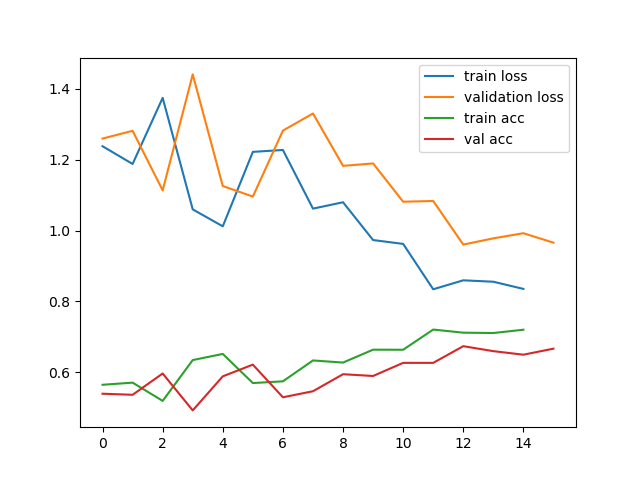

In [52]:
import matplotlib.pyplot as plt
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='validation loss')
plt.legend(loc='upper right')
plt.show()


plt.plot(train_acc, label='train acc')
plt.plot(val_acc, label='val acc')
plt.legend(loc='upper right')
plt.show()

## Test set 

In [53]:
check_accuracy(gpu_model, loader_test, 'test')

Checking accuracy on  test
Got 6617 / 10000 correct (66.17)
loss 0.9708658779502675


(0.9708658779502675, 0.6617)